In [1]:
import matplotlib_inline.backend_inline
import seaborn as sns

sns.set_style(style="white")
sns.set_context("talk")

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")


In [2]:
import h5py
import numpy as np

f = h5py.File('./2D_TwoLayer_Data.jld2', 'r')
grid = f['grid']
snapshots = f['snapshots']

# Initialize the grid of x and y coordinates
x = grid['x'][()]
y = grid['y'][()]

# Grab u, v, and q for all snapshots and layers (we will just use the top layer)
u = snapshots['u']
v = snapshots['v']
q = snapshots['q']

In [3]:
!pip install ../../fluidsf
import fluidsf

# The '9950' index pulls the final snapshot of the simulated data, once the turbulence and energetics are spun-up
sfs_2D_maps = fluidsf.generate_2D_SF_maps(u['9950'][0], v['9950'][0], x, y, 
                                         traditional_type=["LLL"])
                                          #traditional_type=["LLL", "LL", "TT", "LSS"])

sfs_list = fluidsf.generate_structure_functions(u['9950'][0], v['9950'][0], x, y, 
                                         traditional_type=["LLL"])

# The following lines could be used to diagnose structure functions for all snapshots 
# of data, but this is too slow for an example

#sfs_2D_maps = [
#    fluidsf.generate_2D_SF_maps(u[d][0], v[d][0], x, y)
#    for d in u.keys()]

#sfs_list = [
#    fluidsf.generate_structure_functions(u[d][0], v[d][0], x, y)
#    for d in u.keys()]

Processing /Users/brodiepearson/Documents/GitHub/fluidsf
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for fluidsf: filename=fluidsf-0.0.0-py3-none-any.whl size=15552 sha256=c05a15921e313a4a495cf2d158ac71fca0b202863e7adf6354f730f7e391fe18
  Stored in directory: /private/var/folders/s4/b0kf2lp10_xgphdc7j7z3clh0000gn/T/pip-ephem-wheel-cache-i7v8pn2p/wheels/1d/4f/21/69cb52e95b42999ca97ae78018dc45ae8761ebf52634e7b41c
Successfully built fluidsf
  Attempting uninstall: fluidsf
    Found existing installation:

/Users/brodiepearson/opt/miniconda3/lib/python3.9/site-packages/fluidsf/calculate_2D_SF_maps.py:124: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = x_separation / np.sqrt(x_separation**2 + y_separation**2)
/Users/brodiepearson/opt/miniconda3/lib/python3.9/site-packages/fluidsf/calculate_2D_SF_maps.py:125: RuntimeWarning: invalid value encountered in double_scalars
  sine_angle = y_separation / np.sqrt(x_separation**2 + y_separation**2)
/Users/brodiepearson/opt/miniconda3/lib/python3.9/site-packages/fluidsf/calculate_2D_SF_maps.py:128: RuntimeWarning: Mean of empty slice
  SF_dict["SF_LL_xy"] = np.nanmean(
/Users/brodiepearson/opt/miniconda3/lib/python3.9/site-packages/fluidsf/calculate_2D_SF_maps.py:138: RuntimeWarning: Mean of empty slice
  SF_dict["SF_LLL_xy"] = np.nanmean(


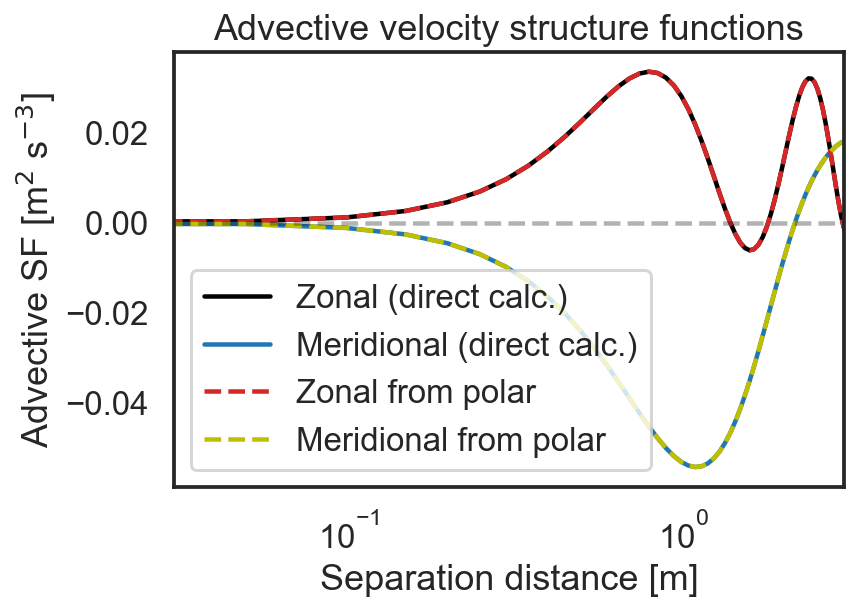

In [4]:
# First, let us check that the polar code calculates the same 
# zonal (purely x-separated) and meridional (purely y-separated)
# structure functions as the core 1D calculation modules

import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots()

ax1.semilogx(sfs_list['x-diffs'], sfs_list['SF_advection_velocity_x'],label=r'Zonal (direct calc.)',color='k')
ax1.semilogx(sfs_list['y-diffs'], sfs_list['SF_advection_velocity_y'], label=r'Meridional (direct calc.)',
             color='tab:blue')
ax1.semilogx(sfs_list['y-diffs'], sfs_2D_maps['SF_velocity_advection_xy'][:,64], label=r'Zonal from polar',
             color='tab:red', linestyle='dashed')
ax1.semilogx(sfs_list['y-diffs'], sfs_2D_maps['SF_velocity_advection_xy'][0,64:], label=r'Meridional from polar',
             color='y', linestyle='dashed')

ax1.set_ylabel(r"Advective SF [m$^2$ s$^{-3}$]")
ax1.set_xlabel(r"Separation distance [m]")
ax1.set_xlim(3e-2,3e0)
ax1.legend()
plt.hlines(0,3e-2,3e0,color='k',linestyle='dashed',alpha=0.3)
plt.title('Advective velocity structure functions');

In [5]:
# Now we construct a 2D map of the advective structure function 
# To do this, note that a separation vector with a positive x and y component 
# is equivalent to a separation vector with negative x and y component, 
# similarly the negative-y positive-x quadrant maps to positive-y negative-x

# First we construct these polar map arrays by appending these quadrants to the two already calculated

TwoD_map_x_separations = np.append(-np.flip(sfs_2D_maps['x_separations']), sfs_2D_maps['x_separations'], axis=0)
TwoD_map_y_separations = np.append(-np.flip(sfs_2D_maps['y_separations']), sfs_2D_maps['y_separations'], axis=0)
TwoD_map_advective_SF = np.append(np.flip(sfs_2D_maps['SF_velocity_advection_xy']), 
                                   sfs_2D_maps['SF_velocity_advection_xy'], axis=0)


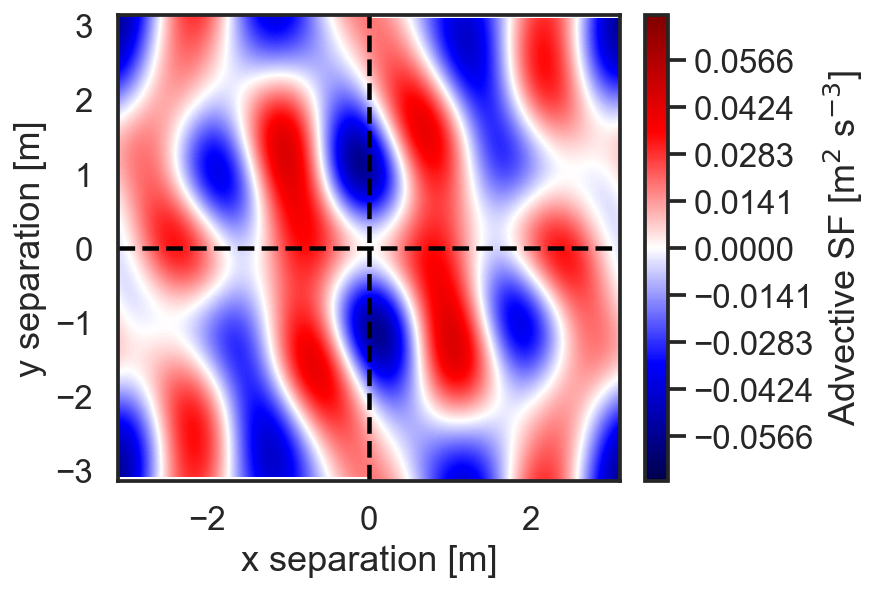

In [6]:
fig1, ax2 = plt.subplots(layout='constrained')

levels = np.linspace(-0.07, 0.07, 1001)

CS = ax2.contourf(TwoD_map_x_separations,
            TwoD_map_y_separations,
            TwoD_map_advective_SF, 
            levels=levels, cmap=plt.cm.seismic)

ax2.set_xlabel('x separation [m]')
ax2.set_ylabel('y separation [m]')

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('Advective SF [m$^2$ s$^{-3}$]')

ax2.axhline(0, color='black', linestyle='--')
ax2.axvline(0, color='black', linestyle='--')


<ipython-input-7-1a419cf3b7b3>:18: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(distances)


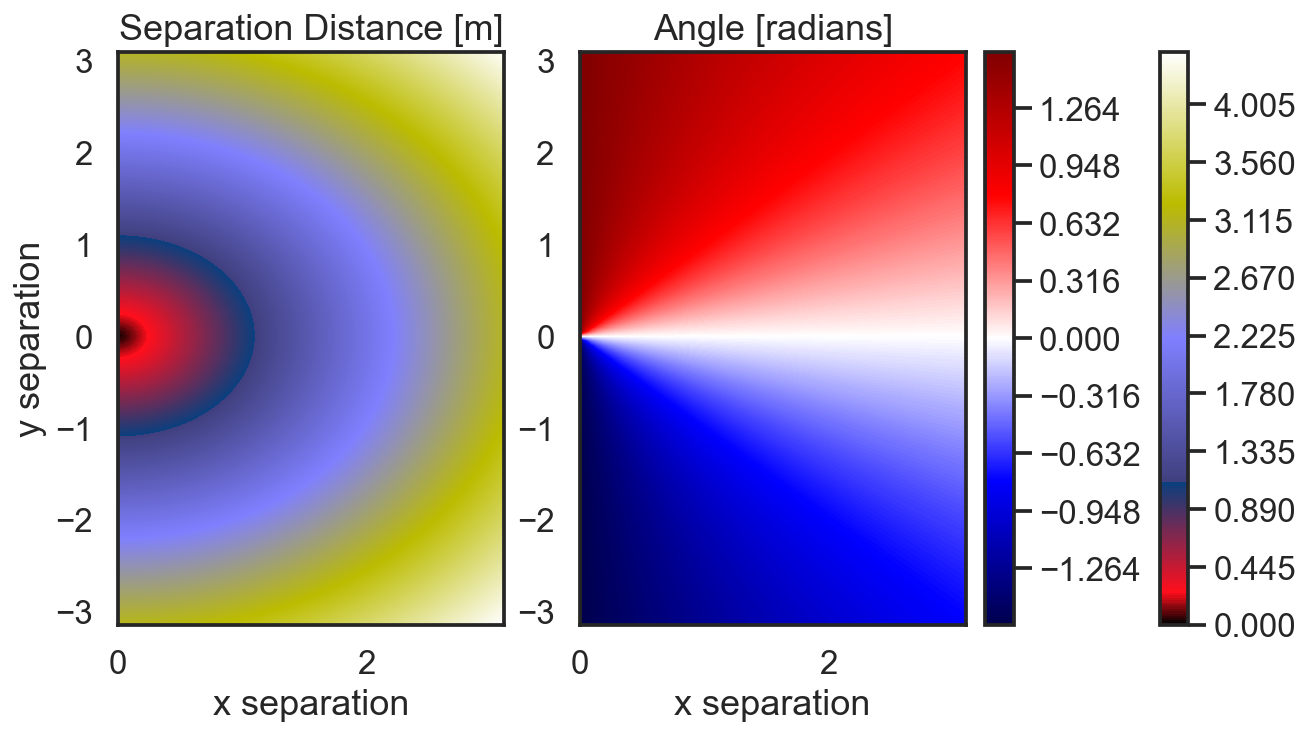

In [7]:
# The 2D map modules also output separation distance and angle
# These could be useful for users, for example when binning or performing analyses
# Although these properties are not used in this example, we visualize them below
# to demonstrate how to access and use these arrays

fig, axs = plt.subplots(1,2, figsize=(9,5), layout='constrained')
                        
distances = axs[0].contourf(sfs_2D_maps['x_separations'],
            sfs_2D_maps['y_separations'],
            sfs_2D_maps['separation_distances'], 
            1000, cmap=plt.cm.gist_stern)

axs[0].set_title('Separation Distance [m]')
axs[0].set_xlabel('x separation')
axs[0].set_ylabel('y separation')

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(distances)

angles = axs[1].contourf(sfs_2D_maps['x_separations'],
            sfs_2D_maps['y_separations'],
            sfs_2D_maps['separation_angles'], 
            1000, cmap=plt.cm.seismic)

axs[1].set_title('Angle [radians]')
axs[1].set_xlabel('x separation')

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(angles)

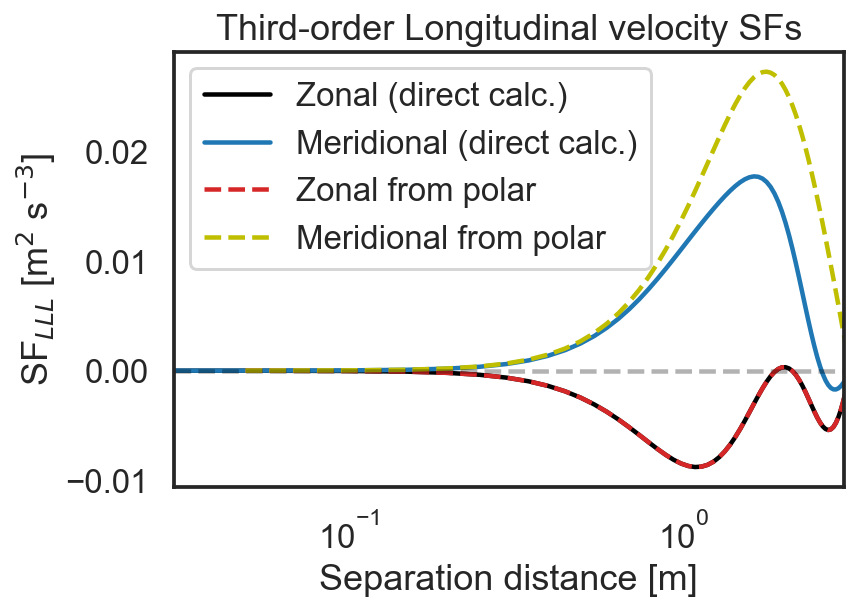

In [10]:
# First, let us check that the polar code calculates the same 
# zonal (purely x-separated) and meridional (purely y-separated)
# structure functions as the core 1D calculation modules

import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots()

ax1.semilogx(sfs_list['x-diffs'], sfs_list['SF_LLL_x'],label=r'Zonal (direct calc.)',color='k')
ax1.semilogx(sfs_list['y-diffs'], sfs_list['SF_LLL_y'], label=r'Meridional (direct calc.)',
             color='tab:blue')
ax1.semilogx(sfs_list['y-diffs'], sfs_2D_maps['SF_LLL_xy'][:,64], label=r'Zonal from polar',
             color='tab:red', linestyle='dashed')
ax1.semilogx(sfs_list['y-diffs'], sfs_2D_maps['SF_LLL_xy'][0,64:], label=r'Meridional from polar',
             color='y', linestyle='dashed')

ax1.set_ylabel(r"SF$_{LLL}$ [m$^2$ s$^{-3}$]")
ax1.set_xlabel(r"Separation distance [m]")
ax1.set_xlim(3e-2,3e0)
ax1.legend()
plt.hlines(0,3e-2,3e0,color='k',linestyle='dashed',alpha=0.3)
plt.title('Third-order Longitudinal velocity SFs');

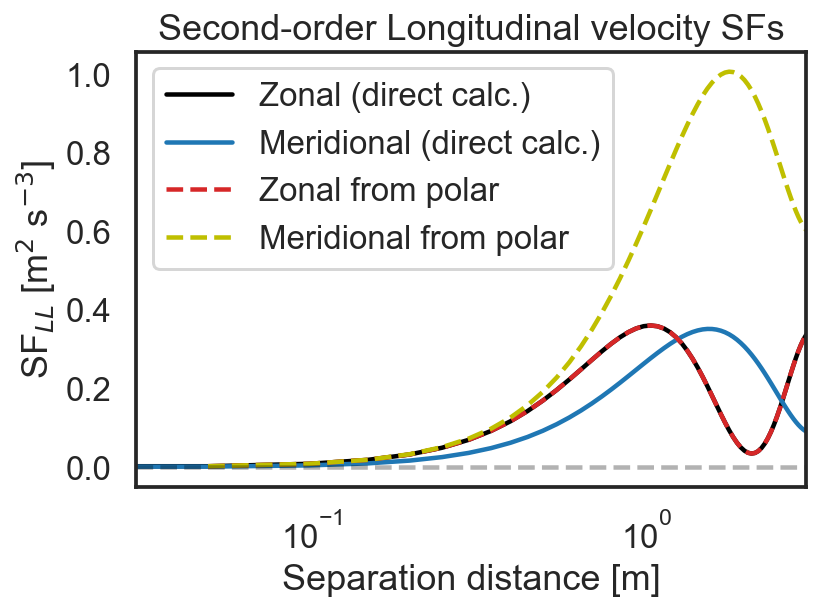

In [11]:
# First, let us check that the polar code calculates the same 
# zonal (purely x-separated) and meridional (purely y-separated)
# structure functions as the core 1D calculation modules

import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots()

ax1.semilogx(sfs_list['x-diffs'], sfs_list['SF_LL_x'],label=r'Zonal (direct calc.)',color='k')
ax1.semilogx(sfs_list['y-diffs'], sfs_list['SF_LL_y'], label=r'Meridional (direct calc.)',
             color='tab:blue')
ax1.semilogx(sfs_list['y-diffs'], sfs_2D_maps['SF_LL_xy'][:,64], label=r'Zonal from polar',
             color='tab:red', linestyle='dashed')
ax1.semilogx(sfs_list['y-diffs'], sfs_2D_maps['SF_LL_xy'][0,64:], label=r'Meridional from polar',
             color='y', linestyle='dashed')

ax1.set_ylabel(r"SF$_{LL}$ [m$^2$ s$^{-3}$]")
ax1.set_xlabel(r"Separation distance [m]")
ax1.set_xlim(3e-2,3e0)
ax1.legend()
plt.hlines(0,3e-2,3e0,color='k',linestyle='dashed',alpha=0.3)
plt.title('Second-order Longitudinal velocity SFs');